In [37]:
import tensorflow as tf
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, MaxPool2D, LSTM

In [2]:
df = pd.read_csv("dataset/Video Information Extraction.csv")

In [3]:
df.head()

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book


We need to remove the identity of the unpreserved video

In [4]:
record = pickle.load(open("final_record_cleaned.pkl", "rb"))

In [5]:
video_id_kept = list(record.keys())
video_id_kept = [int(id.replace('.mp4', '')) for id in video_id_kept]

In [6]:
new_df = df[df["video_id"].isin(video_id_kept)]

In [7]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
8,25,-1,1,11,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,17710,196,15,521,414,drink
12,25,-1,1,19,52,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,17711,289,9,783,480,drink
14,25,-1,1,21,21,asldeafined,test,https://media.asldeafined.com/vocabulary/14677...,0,17713,28,0,542,480,drink
15,25,-1,1,27,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,0,17709,41,9,257,240,drink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11968,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/7/7474.mp4,0,62492,69,16,219,192,waterfall
11969,25,-1,1,6,12,aslsearch,train,http://www.aslsearch.com/signs/videos/waterfal...,0,62493,203,55,549,400,waterfall
11970,25,-1,1,3,19,elementalasl,train,https://elementalaslconcepts.weebly.com/upload...,0,62782,89,4,242,180,weigh
11973,25,-1,1,2,4,signschool,test,https://signstock.blob.core.windows.net/signsc...,0,63044,415,86,1811,1080,wheelchair


Reordering dataframe

In [8]:
new_df = new_df.sort_values(by=["video_id"]) 

In [9]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
8751,25,-1,1,2,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,335,57,5,246,240,abdomen
8752,25,-1,1,3,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14688...,0,336,103,0,565,480,abdomen
8756,25,-1,1,1,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,376,61,5,247,240,able
8757,25,-1,1,2,15,asldeafined,train,https://media.asldeafined.com/vocabulary/14667...,0,377,69,17,552,480,able
1709,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,414,64,27,241,240,about
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
7446,25,-1,1,1,116,aslbrick,train,http://aslbricks.org/New/ASL-Videos/worm.mp4,0,69541,282,4,937,720,worm
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

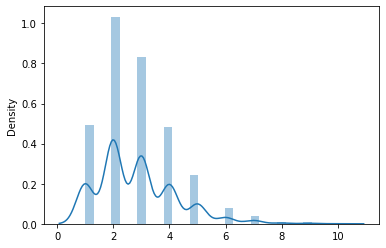

In [10]:
sns.distplot(np.array(new_df["gloss"].value_counts()))

Removing single classes

In [11]:
val_count = dict(new_df["gloss"].value_counts())

In [12]:
single_classes = [key for key in val_count.keys() if val_count[key] == 1]

In [13]:
single_classes

['chicago',
 'cheat',
 'tough',
 'careless',
 'christian',
 'throat',
 'tomato',
 'china',
 't',
 'christ',
 'catholic',
 'child',
 'cereal',
 'children',
 'tobacco',
 'tornado',
 'choke',
 'pickle',
 'cards',
 'whistle',
 'wonder',
 'wish',
 'winter',
 'any',
 'will',
 'arizona',
 'w',
 'wheelchair',
 'card',
 'available',
 'weigh',
 'weekly',
 'award',
 'bake',
 'waste',
 'washington',
 'ahead',
 'worthless',
 'agenda',
 'admit',
 'this',
 'head',
 'book',
 'welcome',
 'vlog',
 'slip',
 'obsess',
 'gallaudet',
 'eye',
 'dice',
 'chicken',
 'brush',
 'zero',
 'across',
 'act',
 'battery',
 'become',
 'berry',
 'bridge',
 'broke',
 'turtle',
 'turn',
 'bull',
 'bully',
 'burp',
 'busy',
 'trouble',
 'trip',
 'tree',
 'camera',
 'cannot',
 'canoe',
 'captain',
 'tower',
 'brochure',
 'u',
 'waiter',
 'bribe',
 'beside',
 'between',
 'b',
 'bible',
 'v',
 'boast',
 'vegetable',
 'value',
 'valley',
 'bookstore',
 'boots',
 'use',
 'boxing',
 'united states',
 'brain',
 'thousand',
 'excu

In [14]:
len(single_classes)

298

In [15]:
new_df = new_df[~new_df["gloss"].isin(single_classes)]

In [16]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
8751,25,-1,1,2,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,335,57,5,246,240,abdomen
8752,25,-1,1,3,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14688...,0,336,103,0,565,480,abdomen
8756,25,-1,1,1,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,376,61,5,247,240,able
8757,25,-1,1,2,15,asldeafined,train,https://media.asldeafined.com/vocabulary/14667...,0,377,69,17,552,480,able
1709,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,414,64,27,241,240,about
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
7446,25,-1,1,1,116,aslbrick,train,http://aslbricks.org/New/ASL-Videos/worm.mp4,0,69541,282,4,937,720,worm
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


Reordering records

In [17]:
sorted_record = { key : record[key] for key in sorted(record.keys()) if int(key.replace(".mp4", "")) in list(new_df["video_id"])}

In [18]:
len(sorted_record)

5235

## Prepare dataset

All video doesn't have the same number of sequence

In [19]:
X = np.array(list(sorted_record.values()))

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(np.array(list(new_df["gloss"])).reshape(-1,1))
y = encoder.transform(np.array(list(new_df["gloss"])).reshape(-1,1)).toarray()

In [20]:
le = LabelEncoder()
y_ = le.fit_transform(np.array(list(new_df["gloss"])))

In [21]:
y_.shape

(5235,)

In [22]:
print(X.shape, y.shape)

(5235, 520, 100, 3) (5235, 1657)


In [23]:
X = X.reshape(X.shape[0], X.shape[2], X.shape[1], X.shape[3])

In [24]:
input_dim = X.shape[1:]
nb_classes = y.shape[-1]

## Model implementation

In [25]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model.add(tf.keras.layers.Reshape((100, 65*32)))
model.add(LSTM(100))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 260, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 130, 16)      38416     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 65, 32)       4640      
                                                                 
 reshape (Reshape)           (None, 100, 2080)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               872400    
                                                                 
 dense (Dense)               (None, 1657)              167357    
                                                                 
Total params: 1,083,037
Trainable params: 1,083,037
Non-

In [31]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.35, random_state=0)

Epoch 1/10
54/54 [==============================] - 234s 4s/step - loss: 7.4385 - accuracy: 8.8183e-04 - val_loss: 7.4184 - val_accuracy: 5.4555e-04
Epoch 2/10
54/54 [==============================] - 231s 4s/step - loss: 7.2897 - accuracy: 0.0109 - val_loss: 7.4419 - val_accuracy: 5.4555e-04
Epoch 3/10
54/54 [==============================] - 227s 4s/step - loss: 7.0965 - accuracy: 0.0141 - val_loss: 7.4862 - val_accuracy: 0.0016
Epoch 4/10
54/54 [==============================] - 226s 4s/step - loss: 6.9055 - accuracy: 0.0244 - val_loss: 7.5422 - val_accuracy: 5.4555e-04
Epoch 5/10
54/54 [==============================] - 225s 4s/step - loss: 6.7391 - accuracy: 0.0300 - val_loss: 7.6341 - val_accuracy: 0.0011
Epoch 6/10
54/54 [==============================] - 228s 4s/step - loss: 6.5870 - accuracy: 0.0367 - val_loss: 7.6948 - val_accuracy: 0.0011
Epoch 7/10
54/54 [==============================] - 201s 4s/step - loss: 6.4023 - accuracy: 0.0459 - val_loss: 7.7275 - val_accuracy: 0.00

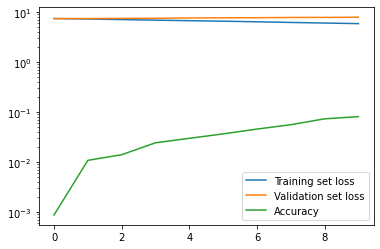

Epoch 1/10
54/54 [==============================] - 190s 4s/step - loss: 6.4801 - accuracy: 0.0673 - val_loss: 6.5979 - val_accuracy: 0.0562
Epoch 2/10
54/54 [==============================] - 201s 4s/step - loss: 6.2835 - accuracy: 0.0747 - val_loss: 6.7020 - val_accuracy: 0.0344
Epoch 3/10
54/54 [==============================] - 196s 4s/step - loss: 6.0934 - accuracy: 0.0917 - val_loss: 6.7868 - val_accuracy: 0.0191
Epoch 4/10
54/54 [==============================] - 198s 4s/step - loss: 5.9059 - accuracy: 0.0947 - val_loss: 6.8769 - val_accuracy: 0.0120
Epoch 5/10
54/54 [==============================] - 197s 4s/step - loss: 5.7830 - accuracy: 0.0988 - val_loss: 6.9947 - val_accuracy: 0.0082
Epoch 6/10
54/54 [==============================] - 196s 4s/step - loss: 5.6659 - accuracy: 0.1079 - val_loss: 7.0530 - val_accuracy: 0.0055
Epoch 7/10
54/54 [==============================] - 197s 4s/step - loss: 5.4943 - accuracy: 0.1205 - val_loss: 7.1360 - val_accuracy: 0.0044
Epoch 8/10
54

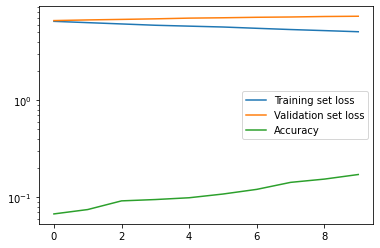

Epoch 1/10
54/54 [==============================] - 201s 4s/step - loss: 5.7588 - accuracy: 0.1211 - val_loss: 5.8828 - val_accuracy: 0.1211
Epoch 2/10
54/54 [==============================] - 196s 4s/step - loss: 5.5535 - accuracy: 0.1420 - val_loss: 6.0017 - val_accuracy: 0.0933
Epoch 3/10
54/54 [==============================] - 196s 4s/step - loss: 5.3905 - accuracy: 0.1514 - val_loss: 6.1105 - val_accuracy: 0.0693
Epoch 4/10
54/54 [==============================] - 196s 4s/step - loss: 5.2226 - accuracy: 0.1664 - val_loss: 6.2347 - val_accuracy: 0.0540
Epoch 5/10
54/54 [==============================] - 197s 4s/step - loss: 5.0923 - accuracy: 0.1764 - val_loss: 6.3332 - val_accuracy: 0.0431
Epoch 6/10
54/54 [==============================] - 203s 4s/step - loss: 4.9515 - accuracy: 0.1961 - val_loss: 6.4243 - val_accuracy: 0.0371
Epoch 7/10
54/54 [==============================] - 205s 4s/step - loss: 4.8134 - accuracy: 0.2105 - val_loss: 6.5204 - val_accuracy: 0.0306
Epoch 8/10
54

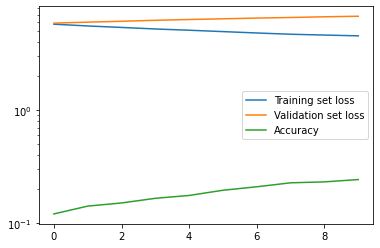

Epoch 1/10
54/54 [==============================] - 201s 4s/step - loss: 5.2617 - accuracy: 0.1711 - val_loss: 5.3582 - val_accuracy: 0.1658
Epoch 2/10
54/54 [==============================] - 195s 4s/step - loss: 5.0811 - accuracy: 0.1905 - val_loss: 5.5054 - val_accuracy: 0.1238
Epoch 3/10
54/54 [==============================] - 196s 4s/step - loss: 4.9171 - accuracy: 0.2049 - val_loss: 5.6426 - val_accuracy: 0.1020
Epoch 4/10
54/54 [==============================] - 195s 4s/step - loss: 4.7825 - accuracy: 0.2178 - val_loss: 5.7666 - val_accuracy: 0.0802
Epoch 5/10
54/54 [==============================] - 198s 4s/step - loss: 4.6540 - accuracy: 0.2302 - val_loss: 5.8578 - val_accuracy: 0.0764
Epoch 6/10
54/54 [==============================] - 195s 4s/step - loss: 4.5383 - accuracy: 0.2528 - val_loss: 5.9574 - val_accuracy: 0.0600
Epoch 7/10
54/54 [==============================] - 195s 4s/step - loss: 4.4355 - accuracy: 0.2613 - val_loss: 6.0423 - val_accuracy: 0.0524
Epoch 8/10
54

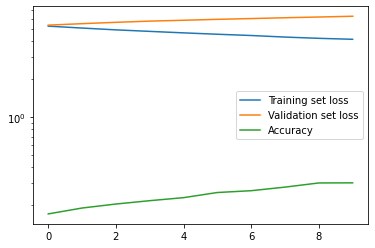

Epoch 1/10
54/54 [==============================] - 198s 4s/step - loss: 4.8675 - accuracy: 0.2160 - val_loss: 4.8751 - val_accuracy: 0.2106
Epoch 2/10
54/54 [==============================] - 196s 4s/step - loss: 4.7183 - accuracy: 0.2299 - val_loss: 5.0872 - val_accuracy: 0.1691
Epoch 3/10
54/54 [==============================] - 196s 4s/step - loss: 4.6153 - accuracy: 0.2319 - val_loss: 5.2719 - val_accuracy: 0.1358
Epoch 4/10
54/54 [==============================] - 202s 4s/step - loss: 4.4599 - accuracy: 0.2516 - val_loss: 5.3810 - val_accuracy: 0.1097
Epoch 5/10
54/54 [==============================] - 207s 4s/step - loss: 4.3037 - accuracy: 0.2687 - val_loss: 5.5214 - val_accuracy: 0.0884
Epoch 6/10
54/54 [==============================] - 192s 4s/step - loss: 4.1961 - accuracy: 0.2840 - val_loss: 5.6231 - val_accuracy: 0.0753
Epoch 7/10
54/54 [==============================] - 191s 4s/step - loss: 4.0916 - accuracy: 0.2966 - val_loss: 5.7217 - val_accuracy: 0.0726
Epoch 8/10
54

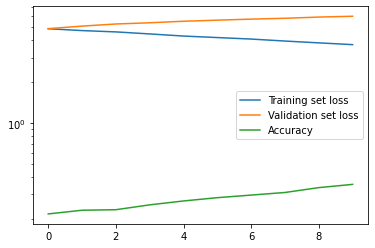

In [32]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy"])

    plt.yscale("log")
    plt.show()

In [ ]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

In [40]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.27733570356556725
Accuracy :  0.2744985673352435
Precision score :  0.3676387078596812
Recall score :  0.2744985673352435


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
